# Reconocimiento de caras

## Samuel Ortega & Pablo Vicente

El objetivo de este proyecto es el de encontrar las caras del dataset de train que más se parecen a las del dataset de test. Para ello utilizaremos PCA y KPCA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import timeit
from utils import get_faces, get_person_num, show_sample_faces, split_train_test,get_stats

### Cargamos el dataset

In [2]:
faces = get_faces(zipfile_path="Grp13Dataset.zip")

In [3]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (80, 70)


In [4]:
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Number of classes: 41
Number of images: 410


Construye la matriz de datos como una matriz en la que cada fila se corresponde con una imagen y cada columna con los píxeles de las imágenes en 1D. Construye también el vector facelabel. 

In [13]:
facematrix_train = []
facelabel_train = []

training_set, testing_set = split_train_test(zipfilepath="Grp13Dataset.zip")

for filename, image in training_set.items():
    # Flatten image into 1D array
    flattened_image = image.flatten()
    # Append flattened image to facematrix
    facematrix_train.append(flattened_image)
    # Extract label from filename
    label = filename.split("/")[0]
    # Append label to facelabel
    facelabel_train.append(label)

# Convert facematrix to numpy array
facematrix_train = np.array(facematrix_train)
# Convert facelabel to numpy array
facelabel_train = np.array(facelabel_train)

In [14]:
n_row, n_col = 4, 5
n_components = n_row * n_col
image_shape = (80, 70)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

C:\Users\pablo\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\pablo\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


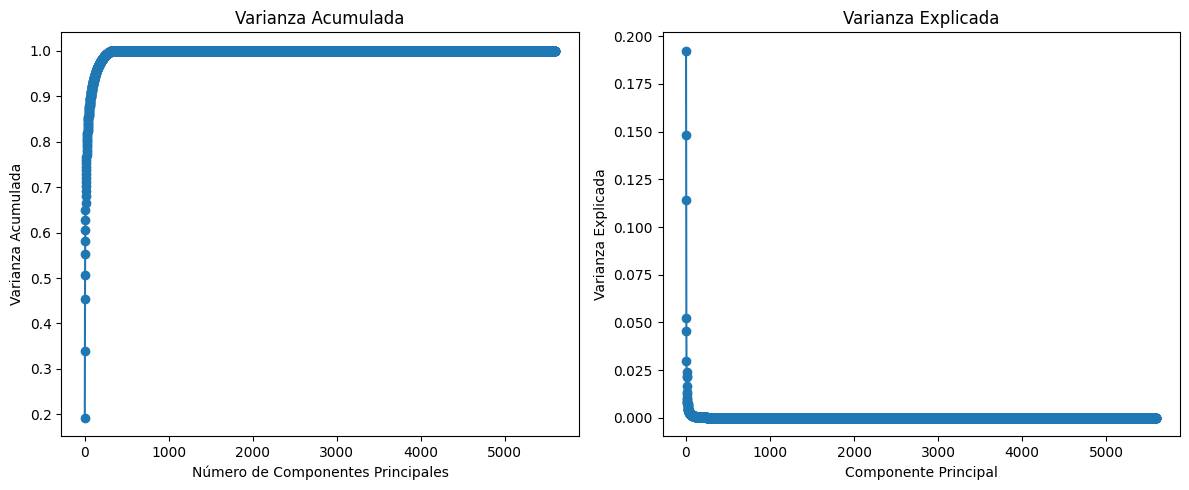

In [39]:
# Calcular la matriz de covarianza
cov_matrix = np.cov(facematrix_train, rowvar=False)

# Calcular los valores y vectores propios
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Ordenar los valores propios de mayor a menor
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Calcular la varianza acumulada y la varianza explicada
variance_explained = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(variance_explained)

# Gráfico de la varianza acumulada
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Varianza Acumulada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')

# Gráfico de la varianza explicada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(variance_explained) + 1), variance_explained, marker='o')
plt.title('Varianza Explicada')
plt.xlabel('Componente Principal')
plt.ylabel('Varianza Explicada')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

Tomando como referencia la gráfica de la varianza explicada, observamos que a partir de alrededor de 50 componentes principales no hay un aporte relevante a la varianza. Por lo tanto, 50 será el máximo de componentes sobre el que probaremos a iterar posteriormente.

# PCA 

Realiza la PCA. Haz pruebas con diferente número de componentes comprobando el error en el acierto.

In [15]:
#Perform mean normalization
mean_face_train = np.mean(facematrix_train, axis=0, keepdims=True)
normalized_faces_train = facematrix_train - mean_face_train
normalized_faces_train -= normalized_faces_train.mean(axis=1).reshape(facematrix_train.shape[0], -1)

Podemos representar la cara promedio del conjunto de el conjunto de entrenamiento, la cual restamos a todas las imágenes para normalizarlas. (Finalmente no se resta la cara promedio al conjunto de entrenamiento porque el porpio método lo hace internamente, se deja este paso explícito porque lo consideramos relevante para el correcto entendimeinto del método)

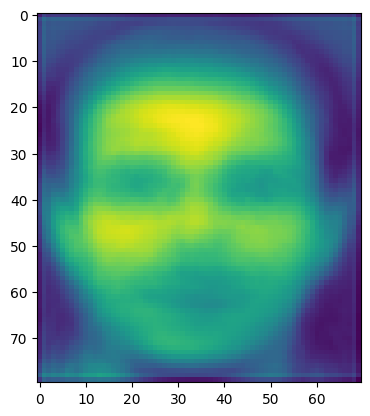

In [11]:
plt.imshow(mean_face_train.reshape(80, 70))

Representa las primeras "eigenfaces" (autovectores) en escala de grises utilizando un subplot. 

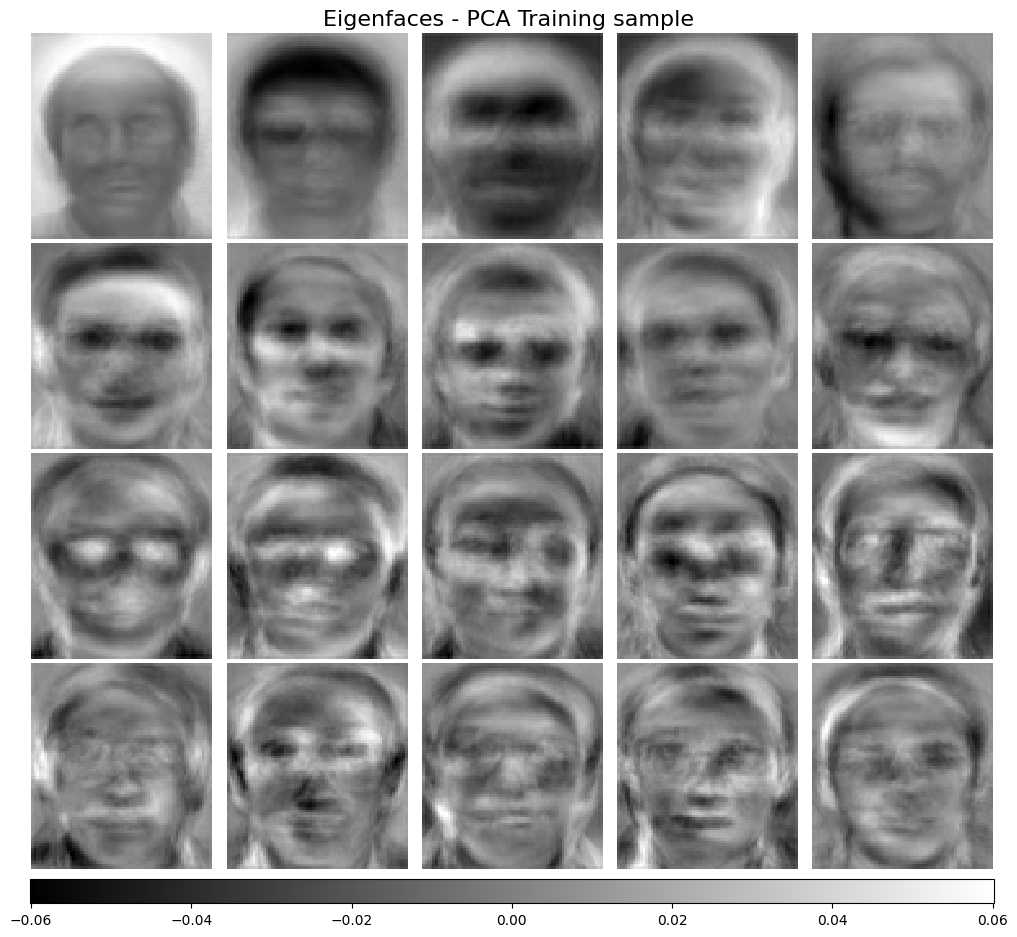

In [16]:
# Obtener las "eigenfaces"
# Representar las "eigenfaces"
n_components = 20
pca_estimator_train =PCA(
    n_components=n_components, whiten=True
)
pca_estimator_train.fit(facematrix_train)
plot_gallery(
    "Eigenfaces - PCA Training sample", pca_estimator_train.components_[:n_components]
)


Completar la función *get_best_match()* para que compare la PCA de train con la PCA de las imágenes de test. Calcula la distancia euclídea entre ambas con la función *np.linalg.norm*.

In [17]:
def get_best_match(filename, doplot = False):
    query = faces[filename].reshape(1, -1)

    # Calcula la distancia euclidiana entre la PCA de train y las imágenes de test
    euclidean_distance = np.linalg.norm(pca_estimator_train.transform(query) - pca_estimator_train.transform(facematrix_train), axis=1)

    # Encuentra el índice del mejor match (la distancia euclidiana más pequeña)
    best_match = np.argmin(euclidean_distance)
    
    #print("Best match %s with Euclidean distance %f" %  (facelabel_train[best_match], euclidean_distance[best_match]))
    person_num, img_num = get_person_num(filename=filename)

    if doplot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
        

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix_train[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match//8) + 1))
        plt.show()

    return (((best_match//8) + 1), person_num)

Llama a la función *get_best_match* y contabiliza las predicciones totales, las correctas y las falsas.

In [18]:
correct_pred = 0
wrong_pred = 0
total_pred = 0
for key, val in testing_set.items(): 
    # Llama a la función get_best_match para obtener la predicción y el valor actual
    predicted, actual = get_best_match(filename=key)
    
    # Incrementa el contador de predicciones totales
    total_pred += 1
    
    # Comprueba si la predicción es correcta y actualiza los contadores correspondientes
    if predicted == actual:
        correct_pred += 1
    else:
        wrong_pred += 1

# Imprime los resultados
print("Utilizando", n_components, "componentes principales en la PCA obtenemos:")
print("Total predictions:", total_pred)
print("Correct predictions:", correct_pred)
print("Wrong predictions:", wrong_pred)
print("Accuracy:", (correct_pred/total_pred*100), "% \n")

Utilizando 20 componentes principales en la PCA obtenemos:
Total predictions: 82
Correct predictions: 78
Wrong predictions: 4
Accuracy: 95.1219512195122 % 



Como podemos osbervar, utilizando unas 20 componentes principales, obtenemos buenos resultados en el proceso de clasificación. No obstante, vamos a comprobar a través de un proceso iterativo cuál esel número óptimo de componentes principales a escoger.

In [19]:
fallos = [] #Guardamos en una lista los ínidces de las personas mal cclasificadas, para comprobar que no se da ningún error sistemático
precision = []

for n_components in range(5, 51, 5):
    
    pca_estimator_train =PCA(
    n_components=n_components, whiten=True
    )

    pca_estimator_train.fit(facematrix_train)

    correct_pred = 0
    wrong_pred = 0
    total_pred = 0

    for key, val in testing_set.items(): 
        # Llama a la función get_best_match para obtener la predicción y el valor actual
        predicted, actual = get_best_match(filename=key)
        
        # Incrementa el contador de predicciones totales
        total_pred += 1
        
        # Comprueba si la predicción es correcta y actualiza los contadores correspondientes
        if predicted == actual:
            correct_pred += 1
        else:
            wrong_pred += 1
            fallos.append(actual)

    # Almacena los resultados
    precision.append(correct_pred/total_pred*100)



Text(0.5, 1.0, 'Precisión de la clasificación en función del número de componenetes principales\n')

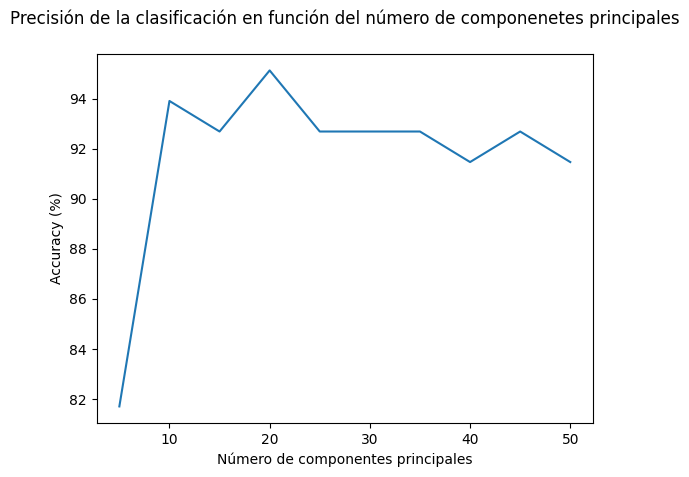

In [20]:
plt.plot(range(5, 51, 5), precision)
plt.xlabel("Número de componentes principales")
plt.ylabel("Accuracy (%)")
plt.title("Precisión de la clasificación en función del número de componenetes principales\n")

Como podemos ver en la gráfica, a partir de 20 componentes principales la precisión alcanza un valor máximo, y pese a que aumentemos el número de componentes no mejora. Por lo tanto, podríamos concluir que el número óptimo de componentes principales a conservar es 20.

# KPCA

Intenta aplicar el mismo procedimiento con KPCA (kernel lineal). Tendrás que hacer algunas traspuestas para conseguirlo.

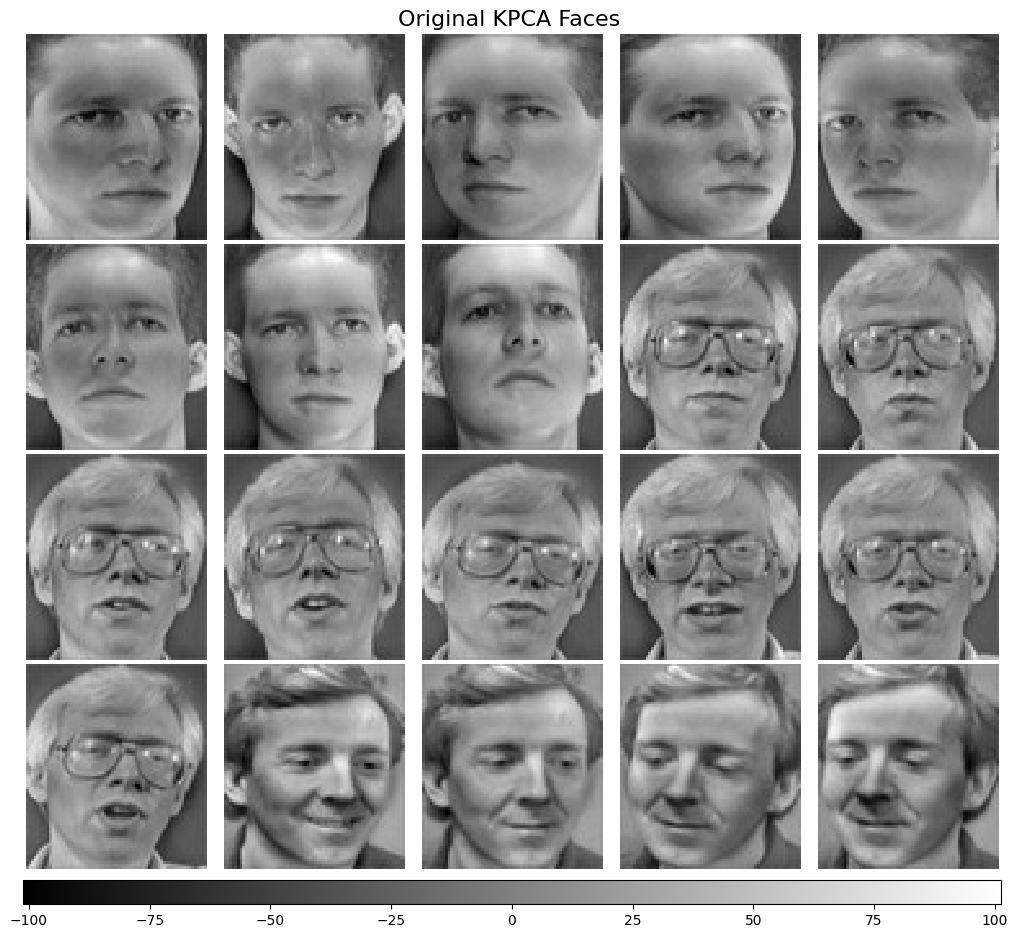

In [41]:
kpca = KernelPCA(kernel= "linear", gamma = 15, degree = 3 ,fit_inverse_transform=True).fit(facematrix_train)


X_kpca = kpca.transform(facematrix_train)
X_kpca_inverse = kpca.inverse_transform(X_kpca)

plot_gallery(
    "Original KPCA Faces", X_kpca_inverse
)

Aquí vemos como, a partir de una estimación, la `KPCA` es capaz de recuperar las fotos de las caras que se le han pasado previamente.

In [21]:
def get_best_match_kpca(filename, doplot = False, n_components=20):
    query = faces[filename].reshape(1, -1)
    kpca = KernelPCA(kernel= "linear", gamma = 15, degree = 3 ,fit_inverse_transform=True, n_components=n_components).fit(facematrix_train)

    # Calcula la distancia euclidiana entre la PCA de train y las imágenes de test
    euclidean_distance = np.linalg.norm(kpca.transform(query) - kpca.transform(facematrix_train), axis=1)

    # Encuentra el índice del mejor match (la distancia euclidiana más pequeña)
    best_match = np.argmin(euclidean_distance)
    
    #print("Best match %s with Euclidean distance %f" %  (facelabel_train[best_match], euclidean_distance[best_match]))
    person_num, img_num = get_person_num(filename=filename)

    if doplot:
        fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
        

        axes[0].imshow(query.reshape(faceshape), cmap="gray")
        axes[0].set_title("Query - Person " + str(person_num))
        axes[1].imshow(facematrix_train[best_match].reshape(faceshape), cmap="gray")
        axes[1].set_title("Best match - Person " + str((best_match//8) + 1))
        plt.show()
    return (((best_match//8) + 1), person_num)

In [23]:
correct_pred = 0
wrong_pred = 0
total_pred = 0
for key, val in testing_set.items(): 
    # Llama a la función get_best_match para obtener la predicción y el valor actual
    predicted, actual = get_best_match_kpca(filename=key, n_components=20)
    
    # Incrementa el contador de predicciones totales
    total_pred += 1
    
    # Comprueba si la predicción es correcta y actualiza los contadores correspondientes
    if predicted == actual:
        correct_pred += 1
    else:
        wrong_pred += 1

# Imprime los resultados
print("Total predictions:", total_pred)
print("Correct predictions:", correct_pred)
print("Wrong predictions:", wrong_pred)
print("Accuracy:", (correct_pred/total_pred*100), "% \n")

Total predictions: 82
Correct predictions: 78
Wrong predictions: 4
Accuracy: 95.1219512195122 % 



Vemos que utilizando la `KPCA` con el kernel lineal, obtenemos una tasa de acierto prácticamente idéntica a la que obtenemo con el método de `PCA`. Esto tiene sentido ya que el método de `KPCA` con un kernel lineal puede interpretarse como una `PCA` al uso.